In [1]:
!git clone https://github.com/maximiliense/GLC

fatal: destination path 'GLC' already exists and is not an empty directory.


In [2]:
from GLC.data_loading.common import load_patch

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import annotations
from pathlib import Path
from typing import Optional, Union, TYPE_CHECKING

import numpy as np
from PIL import Image
import tifffile

In [4]:
df_obs_train = pd.read_csv("../data/observations/observations_fr_train.csv", sep=";", index_col="observation_id", nrows = 10000)

In [5]:
df_obs_train.species_id.values

array([241, 101, 700, ..., 727, 234,  70], dtype=int64)

In [6]:
observation_ids = df_obs_train.index

In [7]:
image = load_patch(observation_ids[0], "../data", data="landcover")

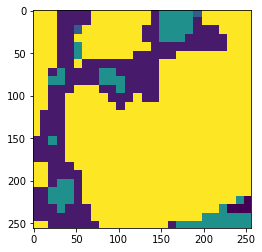

In [8]:
for i in range(0, len(image)):
    plt.imshow(image[i], interpolation='nearest')
    plt.show()

In [9]:
training_data = []
training_label = df_obs_train.species_id.values
for i in observation_ids:
    training_data.append(load_patch(i, "../data", data="rgb")[0])

In [10]:
##for image in training_data:
##    plt.imshow(image, interpolation='nearest')
##    plt.show()
##print(len(training_data), len(training_label))

In [11]:
import os
import torch
import numpy as np
from torch import from_numpy
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
torch.cuda.is_available()

True

In [12]:
def load_landcover(
    observation_id: Union[int, str],
    patches_path: Union[str, Path]
) -> Patches:

    observation_id = str(observation_id)

    region = "patches-fr"
    subfolder1 = observation_id[-2:]
    subfolder2 = observation_id[-4:-2]

    filename = Path(patches_path) / region / subfolder1 / subfolder2 / observation_id

    rgb_filename = filename.with_name(filename.stem + "_rgb.jpg")
    rgb_patch = Image.open(rgb_filename)
    transform = transforms.Compose([transforms.PILToTensor()])
  
    img_tensor = transform(rgb_patch)
    return img_tensor

class CustomImageDataset(Dataset):
    
    def __init__ (self,transform=None, target_transform=None):
        self.img_labels = pd.read_csv("../data/observations/observations_fr_train.csv", sep=";", index_col="observation_id", nrows = 10000).species_id.values
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, index):
        image = load_landcover(observation_ids[index], "../data")
        label = self.img_labels[index]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
        

In [13]:
from GLC.data_loading.pytorch_dataset import GeoLifeCLEF2022Dataset
long_dataset = GeoLifeCLEF2022Dataset("../data",subset = "train", 
                                 region = 'fr', 
                                 patch_data = 'rgb', \
                                 use_rasters = False,\
                                 transform = None)

train_size = 300000
val_size = len(long_dataset) - train_size

short_dataset, rest_dataset = torch.utils.data.random_split(long_dataset, [train_size, val_size])
train_dataset, test_dataset = torch.utils.data.random_split(short_dataset, [299000, 1000])

train_loader = DataLoader(train_dataset, batch_size=1000,num_workers = 0,shuffle = True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers = 0,shuffle = False,drop_last=True)

In [14]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pretrainedmodels
import gc


from torchvision.models.resnet import ResNet, BasicBlock


import torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(196608, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 17036),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    def test(self, x):
        print("jo")
        x = self.flatten(x)
        return len(x[0])        
    
def train(model, train_loader, optimizer, loss_fn):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(train_loader):
        print(i)
        inputs, labels = data
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            last_loss = running_loss / 100
            running_loss = 0.

    return last_loss

model = NeuralNetwork()
model = model.cuda()

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = nn.CrossEntropyLoss(ignore_index = 1)
train(model, train_loader, optimizer, loss_fn)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

9.104897508621216

In [17]:
print(len(train_loader))
print(len(test_loader))
inputs, labels = iter(test_loader).next()


print(model.test(inputs))

299
1000
jo
196608


In [18]:
def is_in_top_30(outputs, species, speciesId):
    values, indices = torch.topk(outputs, 30)
    for i in indices:
        if(species[i] == speciesId):
            return True
    return False

species = df_obs_train.species_id.values
correct = 0
counter = 0

for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs.cuda()
        outputs = model(inputs)
        counter += 1
        for index, item in enumerate(outputs):
            if(is_in_top_30(item, species, labels[index])):
                correct += 1
        
print(correct, " aus " , counter)

27  aus  1000
